In [2]:
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
figsize(12.5, 4)

In [5]:
colors = ["#348ABD", "#A60628"]
prior = [1 / 21, 20 / 21]
posterior = [0.087, 1-0.087]

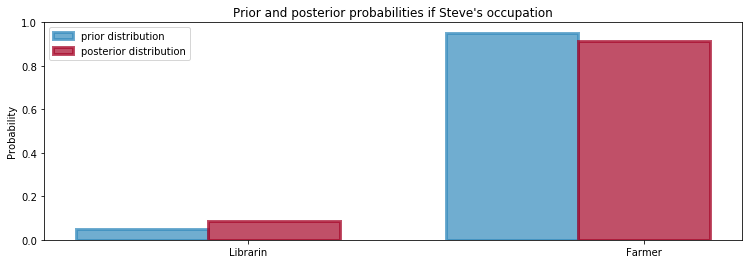

In [12]:
plt.bar([0, .7], prior, alpha=0.70, width=0.25,
       color=colors[0], label="prior distribution",
       lw="3", edgecolor=colors[0])
plt.bar([0 + 0.25, .7 + 0.25], posterior, alpha=0.7,
       width=0.25, color=colors[1],
       label="posterior distribution",
       lw="3", edgecolor="#A60628")
plt.xticks([0.20, 0.95], ["Librarin", "Farmer"])
plt.ylabel("Probability")
plt.legend(loc="upper left")
plt.title("Prior and posterior probabilities if Steve's occupation")

In [16]:
import scipy.stats as stats
figsize(12.5, 4)

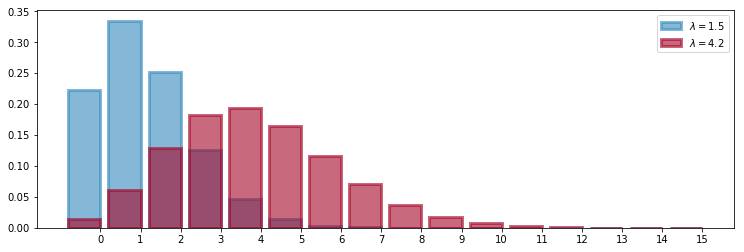

In [20]:
poi = stats.poisson
lambda_ = [1.5, 4.25]
a = np.arange(16)
plt.bar(a, poi.pmf(a, lambda_[0]), color=colors[0],
       label="$\lambda = %.1f$" % lambda_[0],
       alpha=0.60, edgecolor=colors[0], lw="3")
plt.bar(a, poi.pmf(a, lambda_[1]), color=colors[1],
       label="$\lambda = %.1f$" % lambda_[1],
       alpha=0.60, edgecolor=colors[1], lw="3")
plt.xticks(a + 0.4, a)
plt.legend()

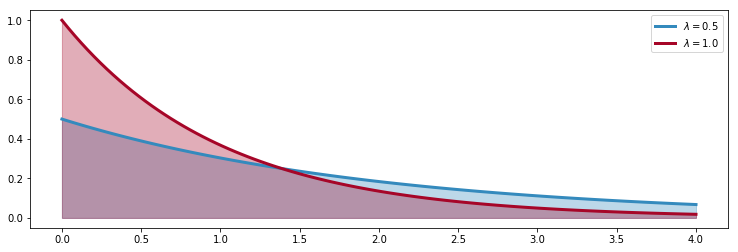

In [23]:
a = np.linspace(0, 4, 100)
expo = stats.expon
lambda_ = [0.5, 1]
for l, c in zip(lambda_, colors):
    plt.plot(a, expo.pdf(a, scale=1. / l), color=c,
       label="$\lambda = %.1f$" % l, lw="3")
    plt.fill_between(a, expo.pdf(a, scale=1. / l),
                    color=c, alpha=.33)
plt.legend()

In [24]:
#フォルダの作成
from os import makedirs
makedirs("data", exist_ok=True)

In [26]:
#データのダウンロード
from urllib.request import urlretrieve
urlretrieve("https://git.io/vXTVC", "data/txdata.csv")

('data/txdata.csv', <http.client.HTTPMessage at 0x118847710>)

(0, 74)

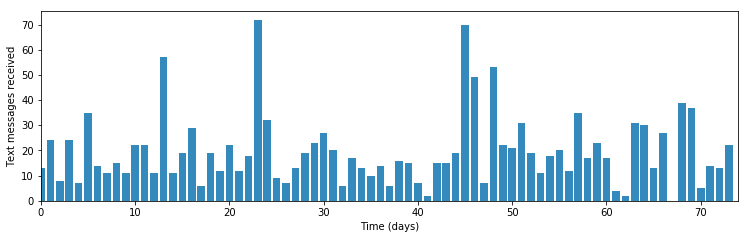

In [30]:
figsize(12.5, 3.5)
count_data = np.loadtxt("data/txdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")

plt.xlabel("Time (days)")
plt.ylabel("Text messages received")
plt.xlim(0, n_count_data)

In [31]:
import pymc as pm

In [32]:
#変数 count_data が計数データを保持している
alpha = 1.0 / count_data.mean()
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)
tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)

In [33]:
@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_count_data)
    out[:tau] = lambda_1
    out[tau:] = lambda_2
    return out

In [34]:
observation = pm.Poisson("obs", lambda_, value=count_data, observed=True)
model = pm.Model([observation, lambda_1, lambda_2, tau])

In [35]:
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000)

 [-----------------100%-----------------] 40000 of 40000 complete in 5.9 sec

In [36]:
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

(15, 30)

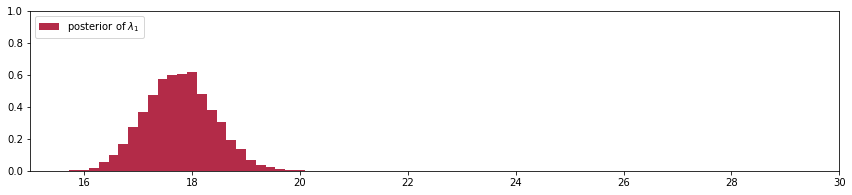

In [40]:
figsize(14.5, 10)

ax = plt.subplot(311)
ax.set_autoscaley_on(False)
plt.hist(lambda_1_samples, histtype='stepfilled',
        bins=30, alpha=0.85, color="#A60628", normed=True,
        label="posterior of $\lambda_1$")
plt.legend(loc="upper left")
plt.xlim([15, 30])

(15, 30)

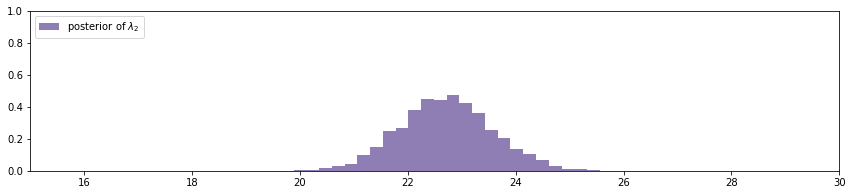

In [41]:
ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled',
        bins=30, alpha=0.85, color="#7A68A6", normed=True,
        label="posterior of $\lambda_2$")
plt.legend(loc="upper left")
plt.xlim([15, 30])

(35, 54)

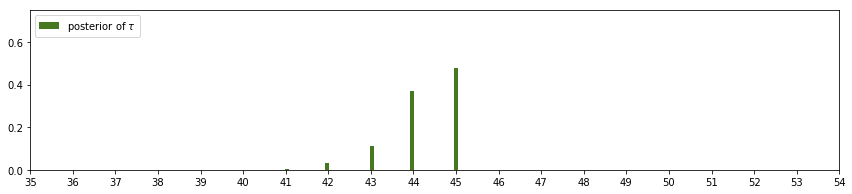

In [45]:
plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
        label=r"posterior of $\tau$", color="#467821",
        weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))
plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data) - 20])

<Container object of 74 artists>

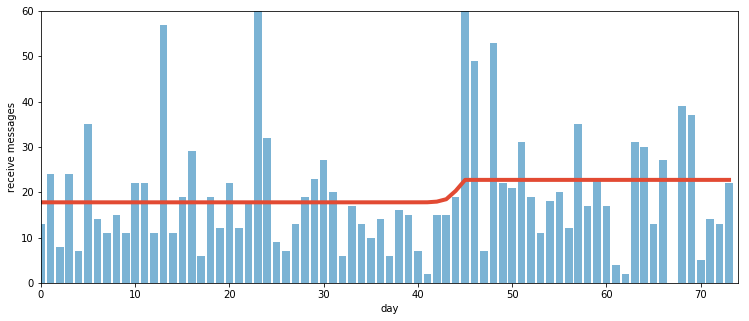

In [54]:
figsize(12.5, 5)

N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    ix = day < tau_samples
    expected_texts_per_day[day] = \
        (lambda_1_samples[ix].sum()
        + lambda_2_samples[~ix].sum()) / N
plt.plot(range(n_count_data), expected_texts_per_day,
        lw=4, color="#E24A33",
         label="Expected number of text messages received")
plt.xlim(0, n_count_data)
plt.ylim(0, 60)
plt.xlabel("day")
plt.ylabel("receive messages")
plt.bar(np.arange(len(count_data)), count_data,
       color="#348ABD", alpha=0.65,
       )